# Behavioral Analysis of Steinmetz Dataset

This notebook analyzes behavioral data and its neural correlates, including:
1. Choice probability analysis
2. Reaction time analysis
3. Sequential effects in behavior
4. Neural prediction of behavior

In [2]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from data_loader import SteinmetzDataLoader
from neural_analysis import NeuralAnalyzer
from behavior_analysis import BehaviorAnalyzer

# Set plotting style
#plt.style.use('seaborn')
sns.set_context("talk")

## 1. Data Loading and Preparation

In [3]:
# Initialize analyzers and load data
loader = SteinmetzDataLoader()
neural_analyzer = NeuralAnalyzer()
behavior_analyzer = BehaviorAnalyzer()

# Load session data
loader.download_data()
session_data = loader.load_session(11)  # Using session 11 as an example

# Generate example behavioral data (replace with actual data when available)
n_trials = len(session_data['spikes'][0])
example_choices = np.random.randint(0, 2, n_trials)
example_outcomes = np.random.randint(0, 2, n_trials)
example_reaction_times = np.random.gamma(shape=5, scale=0.1, size=n_trials)

## 2. Choice Probability Analysis

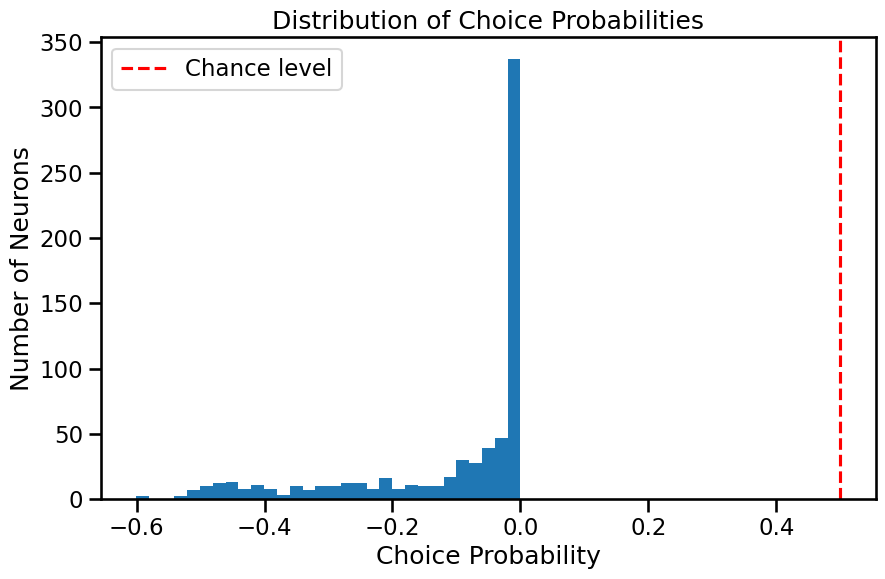

Mean choice probability: -0.107
Significant neurons (p < 0.05): 29


In [4]:
def prepare_choice_data(spikes, choices, time_window=(0, 0.3)):
    """Prepare neural data for choice probability analysis."""
    n_neurons = len(spikes)
    n_trials = len(choices)
    firing_rates = np.zeros((n_neurons, n_trials))
    
    for i in range(n_neurons):
        for j in range(n_trials):
            # Count spikes in the decision window
            trial_spikes = spikes[i][j]
            mask = (trial_spikes >= time_window[0]) & (trial_spikes < time_window[1])
            firing_rates[i, j] = np.sum(mask) / (time_window[1] - time_window[0])
    
    return firing_rates

# Compute firing rates during decision window
firing_rates = prepare_choice_data(session_data['spikes'], example_choices)

# Compute choice probability
choice_probs, p_values = behavior_analyzer.compute_choice_probability(firing_rates, example_choices)

# Plot distribution of choice probabilities
plt.figure(figsize=(10, 6))
plt.hist(choice_probs, bins=30)
plt.axvline(x=0.5, color='r', linestyle='--', label='Chance level')
plt.xlabel('Choice Probability')
plt.ylabel('Number of Neurons')
plt.title('Distribution of Choice Probabilities')
plt.legend()
plt.show()

# Print summary statistics
print(f"Mean choice probability: {np.mean(choice_probs):.3f}")
print(f"Significant neurons (p < 0.05): {np.sum(p_values < 0.05)}")

## 3. Reaction Time Analysis

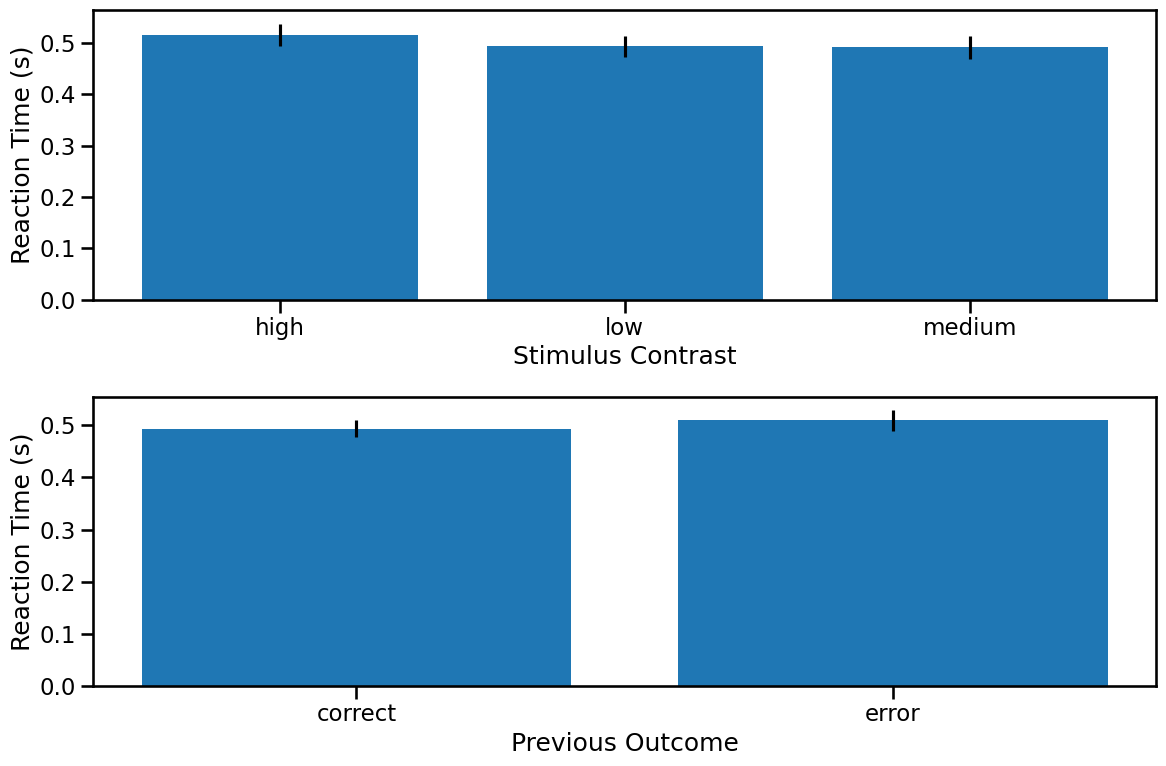

In [5]:
# Create example conditions
conditions = {
    'stimulus_contrast': np.random.choice(['high', 'medium', 'low'], size=n_trials),
    'previous_outcome': np.random.choice(['correct', 'error'], size=n_trials)
}

# Analyze reaction times
rt_results = behavior_analyzer.analyze_reaction_times(example_reaction_times, conditions)

# Plot RT distributions by condition
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot RT by stimulus contrast
contrast_stats = rt_results['stimulus_contrast']
axes[0].bar(range(len(contrast_stats['labels'])), 
           contrast_stats['means'],
           yerr=contrast_stats['sems'])
axes[0].set_xticks(range(len(contrast_stats['labels'])))
axes[0].set_xticklabels(contrast_stats['labels'])
axes[0].set_xlabel('Stimulus Contrast')
axes[0].set_ylabel('Reaction Time (s)')

# Plot RT by previous outcome
outcome_stats = rt_results['previous_outcome']
axes[1].bar(range(len(outcome_stats['labels'])), 
           outcome_stats['means'],
           yerr=outcome_stats['sems'])
axes[1].set_xticks(range(len(outcome_stats['labels'])))
axes[1].set_xticklabels(outcome_stats['labels'])
axes[1].set_xlabel('Previous Outcome')
axes[1].set_ylabel('Reaction Time (s)')

plt.tight_layout()
plt.show()

## 4. Sequential Effects Analysis

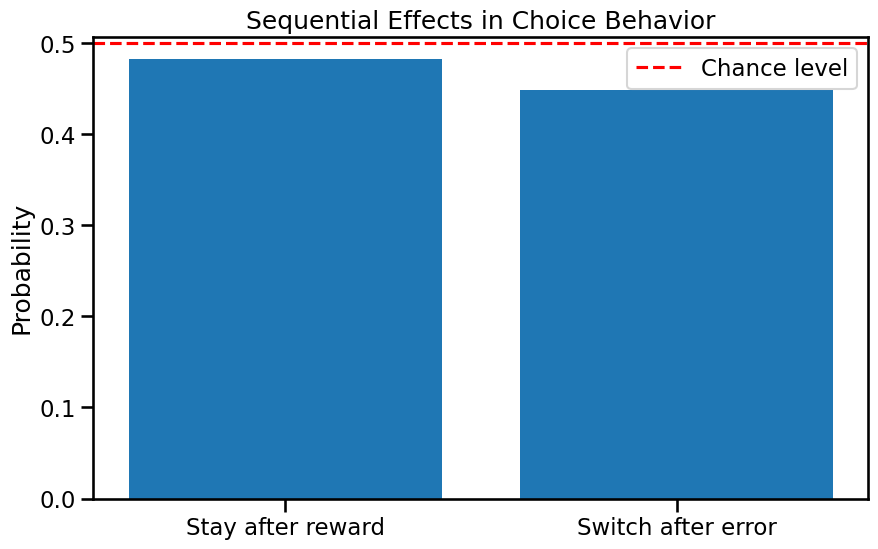

In [6]:
# Analyze sequential effects
seq_effects = behavior_analyzer.compute_sequential_effects(example_choices, example_outcomes)

# Plot sequential effects
plt.figure(figsize=(10, 6))
effects = ['stay_after_reward', 'switch_after_error']
probabilities = [seq_effects[effect] for effect in effects]

plt.bar(range(len(effects)), probabilities)
plt.axhline(y=0.5, color='r', linestyle='--', label='Chance level')
plt.xticks(range(len(effects)), ['Stay after reward', 'Switch after error'])
plt.ylabel('Probability')
plt.title('Sequential Effects in Choice Behavior')
plt.legend()
plt.show()

## 5. Neural Prediction of Choice

/Users/shibanibudhraja/Downloads/Neuromatch/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


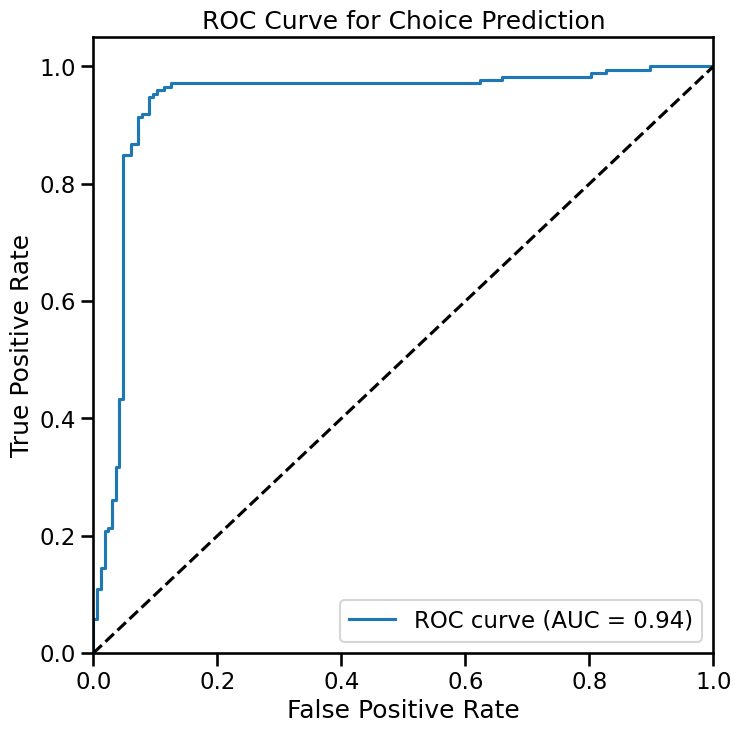

Choice prediction accuracy: 0.559


In [7]:
# Prepare neural features for choice prediction
neural_features = firing_rates.T  # trials x neurons

# Train and evaluate model
accuracy, model = behavior_analyzer.predict_choice(neural_features, example_choices)

# Get predictions for ROC curve
y_pred = model.predict_proba(neural_features)[:, 1]
fpr, tpr, _ = roc_curve(example_choices, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Choice Prediction')
plt.legend(loc="lower right")
plt.show()

print(f"Choice prediction accuracy: {accuracy:.3f}")